# Финальный проект
(Сергеева Юлия)

----------

# Вводные и задача проекта:

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей.  
Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.  

**Проверьте: был ли эксперимент успешен в целом.**

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

-------------

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from urllib.parse import urlencode
import requests

from calendar import monthrange
from datetime import timedelta

%matplotlib inline

from scipy import stats
from scipy.stats import iqr
import pingouin as pg
from scipy.stats import chi2_contingency

from scipy.stats import norm
from tqdm.auto import tqdm

### Загрузка файлов

In [2]:
#внешние ссылки

df_url1 = 'https://disk.yandex.ru/d/4XXIME4osGrMRA'
df_url2 = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg'
df_url3 = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ'
df_url4 = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g'
df_url5 = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ'
df_url6 = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg'

In [3]:
# функция для получения загрузочных ссылок с Яндекс Диска

def get_ds_from_yandex(url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    df_final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(df_final_url)
    download_url = response.json()['href']
    return download_url

In [4]:
users_test = pd.read_csv(get_ds_from_yandex(df_url1), sep = ';')
users_control_1 = pd.read_csv(get_ds_from_yandex(df_url2), sep = ';')
users_control_2 = pd.read_csv(get_ds_from_yandex(df_url3), sep = ';')
transactions_test = pd.read_csv(get_ds_from_yandex(df_url4), sep = ';')
transactions_control_1 = pd.read_csv(get_ds_from_yandex(df_url5), sep = ';')
transactions_control_2 = pd.read_csv(get_ds_from_yandex(df_url6), sep = ';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### Описание данных:

Всего есть три группы: 
* тестовая (test), 
* контрольная 1 (control_1),
* контрольная 2 (control_2).  

Для каждой из них:

**users_*.csv – информация о пользователях:** 

uid – идентификатор пользователя  
age – возраст  
attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки / просмотры *1000)  

coins – число монеток (внутренняя валюта)  
country – страна    
visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)  
gender – пол  
age_filter_start  – фильтр поиска, мин. значение   
age_filter_end  – фильтр поиска, макс. значение   
views_count – число полученных оценок   
was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)  
is_premium –  является ли премиум  
total_revenue – нормированная выручка   


**transactions_*.csv – информация о платежах пользователей:**  

uid – идентификатор пользователя    
country – страна  
joined_at – дата и время регистрации  
paid_at – дата и время покупки  
revenue – нормированная выручка  
payment_id – идентификатор платежа  
from_page – откуда пользователь перешел на страницу оплаты  
product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)   

#### Файлы:

users_test – информация о пользователях в тестовой группе;   
users_control_1 – информация о пользователях в первой контрольной группе;   
users_control_2 – информация о пользователях во второй контрольной группе;     
transactions_test – информация о платежах пользователей в тестовой группе;   
transactions_control_1 – информация о платежах пользователей в первой контрольной группе;   
transactions_control_2 – информация о платежах пользователей во второй контрольной группе.   

----------

# Этапы работы:
- Разведочный анализ исходных данных (EDA) (строки 5 - 107);
- Проверка групп эксперимента на репрезентативность (строки 108 - 110);
- Выбор и обоснование метрик;
- Сравнение метрик в рамках A/A и A/B тестирования и оценка статистической значимости полученных результатов (строки 116 - 155);
- Выводы по результатам анализа.

-----------------------
# Разведочный анализ данных (EDA)

Перед обработкой данных и непосредственно анализом этих данных объединим их, но не будем спешить объединять все таблицы в одну (данные по отдельности могут пригодиться в дальнейшем), а пока объединим таблицы по группам (инфо о пользователях + инфо об их платежах).

In [5]:
# users_test – информация о пользователях в тестовой группе:

users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [6]:
# Размер таблицы:

users_test.shape

(4308, 13)

In [7]:
# Количество уникальных id в ней:

users_test.uid.nunique()

4308

In [8]:
# transactions_test – информация о платежах пользователей в тестовой группе:

transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [9]:
# Размер таблицы:

transactions_test.shape

(273, 8)

In [10]:
# Количество уникальных id в ней:

transactions_test.uid.nunique()

146

In [11]:
# Список уникальных id пользователей из таблицы users_test:
t = users_test.uid.unique().tolist()


# Проверяем, есть ли в таблице transactions_test id пользователей, которых нет в users_test:
transactions_test \
.query('uid not in @t')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [12]:
# Таковых нет, поэтому просто применим ниже left join:

Объединенные данные по тестовой группе:


In [13]:
test_group = pd.merge(users_test, transactions_test, on = 'uid', how='left')

test_group

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,891078639,17,895,NaN,United States of America,"1,2,3,4,5",1,16,20,96,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4431,891188733,27,866,NaN,United States of America,"1,2,3",1,18,41,30,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4432,891293718,48,0,NaN,Argentina,NaN,1,47,51,10,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4433,891192357,32,0,NaN,Australia,NaN,1,16,49,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-----------------------------

In [14]:
# Список уникальных id пользователей из таблицы users_control_1:
t2 = users_control_1.uid.unique().tolist()


# Проверяем, есть ли в таблице transactions_control_1 id пользователей, которых нет в users_control_1:
transactions_control_1 \
.query('uid not in @t2')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
377,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
378,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
379,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
380,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
381,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [15]:
transactions_control_1 \
.query('uid not in @t2') \
.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 630 entries, 377 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           0 non-null      float64
 1   country       0 non-null      object 
 2   joined_at     630 non-null    object 
 3   paid_at       630 non-null    object 
 4   revenue       0 non-null      float64
 5   payment_id    0 non-null      float64
 6   from_page     0 non-null      object 
 7   product_type  0 non-null      object 
dtypes: float64(3), object(5)
memory usage: 44.3+ KB


In [16]:
transactions_control_1['joined_at'] = pd.to_datetime(transactions_control_1['joined_at'], format='%Y-%m-%d %H:%M:%S')
transactions_control_1['paid_at'] = pd.to_datetime(transactions_control_1['paid_at'], format='%Y-%m-%d %H:%M:%S')

transactions_control_1 \
.query('uid not in @t2') \
.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630 entries, 377 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           0 non-null      float64       
 1   country       0 non-null      object        
 2   joined_at     0 non-null      datetime64[ns]
 3   paid_at       0 non-null      datetime64[ns]
 4   revenue       0 non-null      float64       
 5   payment_id    0 non-null      float64       
 6   from_page     0 non-null      object        
 7   product_type  0 non-null      object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 44.3+ KB


In [17]:
# Такие есть, но все нулевые/пустые, смело можем от них отказаться и тоже применить left join:

Объединенные данные по контрольной группе 1:


In [18]:
control_group_1 = pd.merge(users_control_1, transactions_control_1, on = 'uid', how='left')

control_group_1

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4519,892022304,26,227,NaN,United States of America,NaN,0,23,29,427,NaN,NaN,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4520,891905022,38,200,NaN,Argentina,"1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,21",1,20,50,5,NaN,NaN,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4521,891304722,49,411,NaN,United States of America,1,1,46,52,17,NaN,NaN,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4522,891302328,27,0,NaN,United States of America,"1,3,5",1,24,30,0,NaN,NaN,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN


---------------------------

In [19]:
# Список уникальных id пользователей из таблицы users_control_2:
t3 = users_control_2.uid.unique().tolist()


# Проверяем, есть ли в таблице transactions_control_1 id пользователей, которых нет в users_control_2:
transactions_control_2 \
.query('uid not in @t3')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [20]:
# Таковых нет, поэтому также применим ниже left join:

Объединенные данные по контрольной группе 2:


In [21]:
control_group_2 = pd.merge(users_control_2, transactions_control_2, on = 'uid', how='left')

control_group_2

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4400,891937401,63,242,NaN,Italy,"1,2",1,50,66,33,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4401,891692844,35,500,NaN,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4402,891096429,41,333,NaN,United States of America,NaN,1,38,44,6,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4403,891697584,48,210,NaN,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----------------------------

**Изучим и обработаем полные данные тестовой группы, преобразуем их типы при необходимости:**


In [22]:
# размер таблицы:

test_group.shape

(4435, 20)

In [23]:
# информацию о типах данных и их ненулевых значениях в таблице:

test_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4435 entries, 0 to 4434
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4435 non-null   int64  
 1   age               4435 non-null   int64  
 2   attraction_coeff  4435 non-null   int64  
 3   coins             152 non-null    float64
 4   country_x         4435 non-null   object 
 5   visit_days        3104 non-null   object 
 6   gender            4435 non-null   int64  
 7   age_filter_start  4435 non-null   int64  
 8   age_filter_end    4435 non-null   int64  
 9   views_count       4435 non-null   int64  
 10  was_premium       533 non-null    float64
 11  is_premium        274 non-null    float64
 12  total_revenue     4435 non-null   int64  
 13  country_y         273 non-null    object 
 14  joined_at         273 non-null    object 
 15  paid_at           273 non-null    object 
 16  revenue           273 non-null    float64


In [24]:
# количество пустых значений в таблице: 

test_group.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4283
country_x              0
visit_days          1331
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3902
is_premium          4161
total_revenue          0
country_y           4162
joined_at           4162
paid_at             4162
revenue             4162
payment_id          4162
from_page           4162
product_type        4162
dtype: int64

**В тестовой группе есть множество пользователей с пустым значением по колонке visit_days (в какие дни после регистрации пользователь посещал приложение), посмотрим на этих пользователей подробнее, возможно, это те, кто зарегистрировался и больше не заходил в приложение?**

In [25]:
test_group[test_group.visit_days.isna()].query('payment_id != "nan"').head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
140,891919368,29,250,NaN,France,NaN,1,26,32,4,1.0,1.0,16536,France,2017-10-24 21:21:00,2017-10-31 23:21:00,16536.0,147.0,trial_vip_popup,trial_premium
194,891786216,21,250,NaN,Spain,NaN,1,18,24,4,1.0,1.0,12818,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818.0,147.0,trial_vip_popup,trial_premium
226,892211106,33,0,NaN,France,NaN,1,30,36,4,1.0,1.0,4537,France,2017-10-18 17:09:00,2017-10-18 17:31:00,4537.0,147.0,left_sidebar_menu,premium_no_trial
387,892408266,24,0,NaN,France,NaN,1,21,27,1,1.0,1.0,16653,France,2017-10-14 18:47:00,2017-10-23 13:05:00,16653.0,147.0,autoreply_message,trial_premium
542,892084260,53,184,NaN,Canada,NaN,1,50,56,119,1.0,1.0,9815,Canada,2017-10-21 13:30:00,2017-10-28 15:32:00,9815.0,147.0,trial_vip_popup,trial_premium


**Видим, что среди них есть те, кто платил за подписку (paid_at) задолго после регистрации (joined_at), то есть были на платформе, как минимум, 2 дня, что значит, что колонка visit_days немного "бракованная" :(** 

**Будем иметь это в виду при дальнейшем анализе.**

Также почему-то payment_id не уникальные ни по датам покупок, ни по id пользователя.
И никакой закономерности в присвоении payment_id не обнаружено. И судя по описанию данных, payment_id != платежная система.

Также будем иметь это в виду, не опираясь на эту колонку при расчетах.

-----------------

In [26]:
# на всякий случай приводим часть колонок типа object к str во избежание дальнейших ошибок в расчетах: 

test_group.uid = test_group.uid.apply(str)
test_group.gender= test_group.gender.apply(str)
test_group.payment_id = test_group.payment_id.apply(str)
test_group.product_type = test_group.product_type.apply(str)


# и даты к датам: 

test_group['joined_at'] = pd.to_datetime(test_group['joined_at'], format='%Y-%m-%d %H:%M:%S')
test_group['paid_at'] = pd.to_datetime(test_group['paid_at'], format='%Y-%m-%d %H:%M:%S')

In [27]:
# Найдем первые и последние даты в таблице. 
# по дате регистрации:
test_group.joined_at.describe(datetime_is_numeric = True) 

count                              273
mean     2017-09-05 09:39:38.021978112
min                2017-01-11 03:07:00
25%                2017-08-11 03:54:00
50%                2017-10-18 19:20:00
75%                2017-10-23 08:21:00
max                2017-10-31 23:40:00
Name: joined_at, dtype: object

In [28]:
# по дате покупки:
test_group.paid_at.describe(datetime_is_numeric = True) 

count                              273
mean     2017-09-05 17:54:49.230768896
min                2017-01-11 04:37:00
25%                2017-07-11 21:21:00
50%                2017-10-22 16:23:00
75%                2017-10-29 05:50:00
max                2017-12-11 22:06:00
Name: paid_at, dtype: object

In [29]:
# Во тестовой группе все данные за 2017 год.

In [30]:
# Проверим, нет ли ошибок в данных, например, случаев, где дата покупки идет раньше, чем дата регистрации: 

test_group[test_group.paid_at < test_group.joined_at]


,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
44,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305.0,19.0,empty_likes,coins
45,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,Italy,2017-10-31 14:16:00,2017-04-11 06:46:00,6305.0,19.0,autorefill,coins
47,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,Italy,2017-10-31 14:16:00,2017-02-11 11:45:00,6305.0,19.0,autorefill,coins
187,891882681,36,408,76.0,Belgium,"1,2,3,5,6,7,8,9,10,11,12,14,16,17,18,19,20,21",1,33,39,71,1.0,1.0,20410,Belgium,2017-10-25 17:25:00,2017-04-11 10:26:00,7813.0,146.0,empty_likes,coins
194,891786216,21,250,NaN,Spain,NaN,1,18,24,4,1.0,1.0,12818,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818.0,147.0,trial_vip_popup,trial_premium
368,892057347,29,366,2.0,France,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,26,32,251,1.0,1.0,30459,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209.0,19.0,none,coins
371,892057347,29,366,2.0,France,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,26,32,251,1.0,1.0,30459,France,2017-10-21 23:15:00,2017-03-11 03:11:00,1209.0,19.0,none,coins
397,891700323,45,211,NaN,France,"1,2,3,4,5",1,42,48,109,1.0,1.0,16471,France,2017-10-29 13:19:00,2017-05-11 15:20:00,16471.0,147.0,trial_vip_popup,trial_premium
509,891654090,29,326,248.0,United States of America,"1,2,3,4,5,6,8",1,26,32,49,1.0,1.0,38155,United States of America,2017-10-30 05:59:00,2017-07-11 07:38:00,16328.0,147.0,trial_vip_popup,trial_premium
606,891640689,33,500,NaN,France,NaN,1,16,36,2,1.0,1.0,16432,France,2017-10-30 13:47:00,2017-06-11 17:31:00,16432.0,147.0,none,trial_premium


In [31]:
# Такие кейсы нашлись, посчитаем их кол-во по уникальным id:

test_group[test_group.paid_at < test_group.joined_at].uid.nunique()


35

In [32]:
# нашлось 35 uid (только в тестовой группе). 
# В этих кейсах подозрительно то, что дата покупки во всех случаях - 11е число какого-либо месяца.
# Возможно, тут перепутаны местами дата и месяц?
# Посмотрим на список дат оплаты, где число = 11 : 

test_group[test_group.paid_at.dt.day == 11].paid_at.unique()

array(['2017-10-11T11:29:00.000000000', '2017-09-11T15:44:00.000000000',
       '2017-04-11T06:46:00.000000000', '2017-02-11T11:45:00.000000000',
       '2017-05-11T14:02:00.000000000', '2017-12-11T16:05:00.000000000',
       '2017-09-11T04:27:00.000000000', '2017-04-11T10:26:00.000000000',
       '2017-11-11T10:49:00.000000000', '2017-03-11T20:20:00.000000000',
       '2017-08-11T01:56:00.000000000', '2017-03-11T03:11:00.000000000',
       '2017-05-11T15:20:00.000000000', '2017-05-11T08:12:00.000000000',
       '2017-04-11T15:12:00.000000000', '2017-04-11T13:35:00.000000000',
       '2017-07-11T07:38:00.000000000', '2017-11-11T23:51:00.000000000',
       '2017-08-11T08:46:00.000000000', '2017-11-11T20:13:00.000000000',
       '2017-06-11T17:31:00.000000000', '2017-07-11T11:28:00.000000000',
       '2017-05-11T15:26:00.000000000', '2017-07-11T11:27:00.000000000',
       '2017-07-11T19:22:00.000000000', '2017-07-11T21:21:00.000000000',
       '2017-03-11T22:06:00.000000000', '2017-05-11

В записях вида YYYY-MM-DD  MM не превышает 12, что снимает подозрение о том, что на место MM у нас ошибочно попали дни (числа месяца).  
Вероятно, имела место ошибка в записи данных о дате регистрации / дате оплаты.  

По-хорошему, даже если мы исключим записи о таких юзерах (пытаясь получить корректные данные только о новых пользователях
в анализе), это не гарантирует нам отсутствие ошибок в оставшихся данных и наличие только-новых пользователей
(с учетом того, что дата решистрации известна только по пользователям с покупками).  

Хорошо бы найти и поправить этот баг, но не имея такой возможности, будем считать, что баг только в конкретно этих записях.  

Ниже исключим эти id из анализа.

In [33]:
test_date_errors_id_list = test_group[test_group.paid_at < test_group.joined_at].uid.unique()

In [34]:
# Перезаписываем таблицу тестовой группы, исключая юзеров, по которым нашлись багованные данные по датам:

test_group = test_group.query('uid not in @test_date_errors_id_list')

---------------------
**Таким же образом изучим и обработаем полные данные первой контрольной группы, преобразуем их типы при необходимости:**


In [35]:
# размер таблицы:

control_group_1.shape

(4524, 20)

In [36]:
# информацию о типах данных и их ненулевых значениях в таблице:

control_group_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4524 entries, 0 to 4523
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               4524 non-null   int64         
 1   age               4524 non-null   int64         
 2   attraction_coeff  4524 non-null   int64         
 3   coins             215 non-null    float64       
 4   country_x         4524 non-null   object        
 5   visit_days        3200 non-null   object        
 6   gender            4524 non-null   int64         
 7   age_filter_start  4524 non-null   int64         
 8   age_filter_end    4524 non-null   int64         
 9   views_count       4524 non-null   int64         
 10  was_premium       605 non-null    float64       
 11  is_premium        339 non-null    float64       
 12  total_revenue     4524 non-null   int64         
 13  country_y         377 non-null    object        
 14  joined_at         377 no

In [37]:
# количество пустых значений в таблице: 

control_group_1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4309
country_x              0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3919
is_premium          4185
total_revenue          0
country_y           4147
joined_at           4147
paid_at             4147
revenue             4147
payment_id          4147
from_page           4147
product_type        4147
dtype: int64

**В контрольной группе № 1 ситуация с описанием данных аналогичная.**

In [38]:
# Также приводим часть колонок типа object к str во избежание дальнейших ошибок в расчетах: 

control_group_1.uid = control_group_1.uid.apply(str)
control_group_1.gender= control_group_1.gender.apply(str)
control_group_1.payment_id = control_group_1.payment_id.apply(str)
control_group_1.product_type = control_group_1.product_type.apply(str)


# и даты к датам: 

control_group_1['joined_at'] = pd.to_datetime(control_group_1['joined_at'], format = '%Y-%m-%d %H:%M:%S')
                                              
control_group_1['paid_at'] = pd.to_datetime(control_group_1['paid_at'], format = '%Y-%m-%d %H:%M:%S')

In [39]:
# Также найдем первые и последние даты в таблице. 
# по дате регистрации:
control_group_1.joined_at.describe(datetime_is_numeric = True)           

count                              377
mean     2017-08-22 02:04:00.636604672
min                2015-01-19 11:49:00
25%                2017-06-11 17:23:00
50%                2017-10-16 22:33:00
75%                2017-10-22 22:07:00
max                2017-10-31 22:17:00
Name: joined_at, dtype: object

In [40]:
# по дате покупки:
control_group_1.paid_at.describe(datetime_is_numeric = True)           

count                              377
mean     2017-09-05 07:39:33.262599680
min                2016-12-14 16:16:00
25%                2017-07-11 12:47:00
50%                2017-10-17 00:40:00
75%                2017-10-28 03:14:00
max                2017-12-11 21:57:00
Name: paid_at, dtype: object

In [41]:
# данные контрольной группы №1 без учета пустых значений по joined_at:

control_group_1.query('joined_at != "NaT"').sort_values('joined_at').head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
525,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
526,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
527,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type
3560,891561825,32,208,8.0,France,"1,2,3,4,5,8,11",1,29,35,24,1.0,1.0,20449,France,2017-01-11 01:06:00,2017-08-11 03:06:00,12636.0,147.0,trial_vip_popup,trial_premium
3562,891561825,32,208,8.0,France,"1,2,3,4,5,8,11",1,29,35,24,1.0,1.0,20449,France,2017-01-11 01:06:00,2017-04-11 23:21:00,3900.0,19.0,empty_likes,coins


In [42]:
# в первой контрольной группе есть 1 юзер из России, зарегистрировавшийся в 2015 году с покупками в 2016 году, 
# все остальные данные - за 2017 год.
# При этом у этого юзера относительно низкие чеки по этим покупка, и судя по from_page = refund_VP, это какие-то возраты.
# К тому же, по нему неверно посчитан total revenue (c другими пользователями такой проблемы не наблюдается).

# На всякий случай исключим этого юзера из таблицы:

In [43]:
control_group_1 = control_group_1.query('uid != "960936960"')

In [44]:
# описательная статистика по датам в столбце joined_at:

control_group_1.joined_at.describe(datetime_is_numeric = True)           

count                              374
mean     2017-08-29 16:06:22.620320768
min                2017-01-11 01:06:00
25%                2017-06-11 18:24:15
50%                2017-10-17 01:49:00
75%                2017-10-23 08:12:15
max                2017-10-31 22:17:00
Name: joined_at, dtype: object

In [45]:
# описательная статистика по датам в столбце paid_at:

control_group_1.paid_at.describe(datetime_is_numeric = True)   

count                              374
mean     2017-09-07 10:35:57.914438656
min                2017-01-11 02:56:00
25%                2017-07-11 19:54:15
50%                2017-10-17 01:49:00
75%                2017-10-28 04:24:30
max                2017-12-11 21:57:00
Name: paid_at, dtype: object

In [46]:
control_1_date_errors_id_list = control_group_1[control_group_1.paid_at < control_group_1.joined_at].uid.unique()

# Перезаписываем таблицу контрольной группы №1, исключая юзеров, по которым нашлись багованные данные по датам:

control_group_1 = control_group_1.query('uid not in @control_1_date_errors_id_list')

---------------------
**Таким же образом изучим и обработаем полные данные второй контрольной группы, преобразуем их типы при необходимости:**


In [47]:
# размер таблицы:

control_group_2.shape

(4405, 20)

In [48]:
# информацию о типах данных и их ненулевых значениях в таблице:

control_group_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4405 entries, 0 to 4404
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4405 non-null   int64  
 1   age               4405 non-null   int64  
 2   attraction_coeff  4405 non-null   int64  
 3   coins             167 non-null    float64
 4   country_x         4405 non-null   object 
 5   visit_days        3040 non-null   object 
 6   gender            4405 non-null   int64  
 7   age_filter_start  4405 non-null   int64  
 8   age_filter_end    4405 non-null   int64  
 9   views_count       4405 non-null   int64  
 10  was_premium       548 non-null    float64
 11  is_premium        311 non-null    float64
 12  total_revenue     4405 non-null   int64  
 13  country_y         328 non-null    object 
 14  joined_at         328 non-null    object 
 15  paid_at           328 non-null    object 
 16  revenue           328 non-null    float64


In [49]:
# количество пустых значений в таблице: 

control_group_2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4238
country_x              0
visit_days          1365
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3857
is_premium          4094
total_revenue          0
country_y           4077
joined_at           4077
paid_at             4077
revenue             4077
payment_id          4077
from_page           4077
product_type        4077
dtype: int64

**И в контрольной группе № 2 ситуация с описанием данных аналогичная.**

In [50]:
# Также приводим часть колонок типа object к str во избежание дальнейших ошибок в расчетах: 

control_group_2.uid = control_group_2.uid.apply(str)
control_group_2.gender= control_group_2.gender.apply(str)
control_group_2.payment_id = control_group_2.payment_id.apply(str)
control_group_2.product_type = control_group_2.product_type.apply(str)


# и даты к датам: 

control_group_2['joined_at'] = pd.to_datetime(control_group_2['joined_at'], format='%Y-%m-%d %H:%M:%S')
control_group_2['paid_at'] = pd.to_datetime(control_group_2['paid_at'], format='%Y-%m-%d %H:%M:%S')

In [51]:
# Также найдем первые и последние даты в таблице. 
# по дате регистрации:
control_group_2.joined_at.describe(datetime_is_numeric = True) 

count                              328
mean     2017-09-19 07:38:22.499999744
min                2017-01-11 08:36:00
25%                2017-10-13 09:36:45
50%                2017-10-20 14:49:00
75%                2017-10-26 01:40:00
max                2017-10-31 17:43:00
Name: joined_at, dtype: object

In [52]:
# по дате покупки:
control_group_2.paid_at.describe(datetime_is_numeric = True)      

count                              328
mean     2017-09-04 16:16:01.463414784
min                2017-01-11 05:34:00
25%                2017-07-11 13:26:30
50%                2017-10-22 00:15:00
75%                2017-10-28 13:35:00
max                2017-12-11 23:28:00
Name: paid_at, dtype: object

In [53]:
# Во второй контрольной группе все данные за 2017 год.

Итого, во всех таблицах   
первая дата регистрации - 2017-01-11, последняя - 2017-10-31,
первая дата покупки - 2017-01-11, последняя - 2017-12-11.

То есть эксперимент проходил в течение года, что дает нам дополнительную уверенность в том, что сезонный фактор не подпортил нам статистику, а также косвенно указывает на то, что была набрана стат. мощность (долго копили нужный объем данных).


НО важно учесть и помнить, что значения по датам регистрации и покупки не-пустые только у пользователей, которые совершали покупки! По остальным юзерам нет даты регистрации.

In [54]:
control_2_date_errors_id_list = control_group_2[control_group_2.paid_at < control_group_2.joined_at].uid.unique()

# Перезаписываем таблицу контрольной группы №2, исключая юзеров, по которым нашлись багованные данные по датам:

control_group_2 = control_group_2.query('uid not in @control_2_date_errors_id_list')

---------------------------

In [55]:
# Проверим значимость колонки was_premium для нашего анализа 
# (можно ли по ней ориентироваться на пользователей как на тех, кто купил премиум впервые)

test_uids_with_prem_were_prem = test_group \
.query('was_premium == "1" and product_type == "trial_premium" or product_type == "premium_no_trial"') \
.uid \
.to_list()


# список пользователей из тестовой группы, у которых была премиальная покупка и есть статус "был когда-либо премиум"
test_group.query('uid in @test_uids_with_prem_were_prem') \
.groupby('uid') \
.agg({'product_type': 'count'}) \
.sort_values('product_type', ascending = False)

,product_type
uid,
892236423,14
891318459,6
891174411,6
891508155,5
891447105,4
...,...
891531897,1
891499695,1
891478452,1


In [56]:
# посмотрим на список покупок одного из таких пользователей в хронологическом порядке:

test_group.query('uid == "892236423"').sort_values('paid_at')

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
429,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-18 01:15:00,6292.0,147.0,left_sidebar_menu,premium_no_trial
435,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-18 01:33:00,1261.0,19.0,empty_likes,coins
424,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261.0,19.0,empty_likes,coins
431,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,3783.0,67.0,empty_likes,other_type
433,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261.0,19.0,empty_likes,coins
434,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,6305.0,19.0,empty_likes,coins
428,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-22 22:09:00,12610.0,19.0,empty_likes,coins
426,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,31525.0,19.0,menu,coins
427,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,12610.0,19.0,menu,coins
432,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,3783.0,67.0,menu,other_type


**Видим, что даже в день покупки премиума (в день регистрации), у него уже есть статус "был когда-либо премиум".**


(Вообще в целом лишний шаг, т.к. это логично ввиду того, что was_premium - данные из таблицы с уникальными id, 
другого исхода и не стоило ждать, но лучше перебдеть).

**Итого, колонка was_premium нам в анализе никак не поможет.**


In [57]:
# Также обратим внимание на статус is_premium –  является премиум.
# Для проверки данных по этой колонке объединим все данные в одну таблицу.

Объединим данных трех групп, участвующих в тесте, в одну таблицу, предварительно добавив в каждую из них столбец, обозначающий группу, присвоенную каждому юзеру:

In [58]:
test_group["group"] = 'test'
control_group_1["group"] = 'control_1'
control_group_2["group"] = 'control_2'

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
df_merged = test_group.append(control_group_1, sort = False).append(control_group_2, sort = False)


In [60]:
# список пользователей, которые покупали премиум или пробный премиум:
bought_premium_uids = df_merged.query('product_type == "premium_no_trial" or product_type == "trial_premium"').uid.unique().tolist()


# уберем этих пользователей из тотал-данных и оставим только тех, у кого статус "is_premium":
df_merged.query('is_premium == 1 and uid not in @bought_premium_uids')

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
212,891194670,38,583,NaN,Germany,"1,2",1,34,44,12,...,1.0,0,NaN,NaT,NaT,NaN,nan,NaN,nan,test
440,891129669,30,275,NaN,United Kingdom (Great Britain),"1,2,3,4,5",1,27,33,87,...,1.0,0,NaN,NaT,NaT,NaN,nan,NaN,nan,test
449,891219834,21,333,NaN,United States of America,NaN,1,18,24,3,...,1.0,0,NaN,NaT,NaT,NaN,nan,NaN,nan,test
578,891154932,23,750,NaN,United Arab Emirates,NaN,1,20,26,12,...,1.0,0,NaN,NaT,NaT,NaN,nan,NaN,nan,test
751,891242403,38,533,NaN,Spain,"1,2,3",1,30,40,45,...,1.0,1456,Spain,2017-06-11 22:47:00,2017-07-11 19:22:00,728.0,146.0,menu,coins,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247,891095322,30,0,NaN,Italy,NaN,1,16,44,4,...,1.0,0,NaN,NaT,NaT,NaN,nan,NaN,nan,control_2
4262,891392658,39,0,NaN,Canada,"2,3",1,36,42,0,...,1.0,0,NaN,NaT,NaT,NaN,nan,NaN,nan,control_2
4273,891195897,24,428,NaN,United States of America,"1,2,3,4,5",1,23,34,14,...,1.0,0,NaN,NaT,NaT,NaN,nan,NaN,nan,control_2
4324,891097317,29,1000,NaN,Canada,NaN,1,26,32,1,...,1.0,0,NaN,NaT,NaT,NaN,nan,NaN,nan,control_2


**Видим, что в данных есть 132 записи о пользователях, у которых статус говорит о их премиальности, и при этом в рамках нашего эксперимента они не покупали премиум.**

То есть на самом деле в эксперименте участвовали не только новые пользователи?
Либо есть баг в присвоении значения is_premium?

Узнать наверняка, какое из предположений верное, мы сейчас не можем. 


In [61]:
# скольких уникальных пользователей это зааффектило?
df_merged.query('is_premium == 1 and uid not in @bought_premium_uids').uid.nunique()

120

In [62]:
df_merged.query('is_premium == 1 and uid not in @bought_premium_uids').query('paid_at != "NaT"').uid.nunique()

9

In [63]:
# 120 пользователей, 9 из которых совершали покупки в рамках эксперимента.

**Но предположим, что верно второе предположение (баг в присвоении значения is_premium). В таком случае мы просто не будем опираться на столбец is_premium при дальнейшем анализе.**

**В случае же, если верно утверждение, что в эксперименте участвовали не только новые пользователи, исключив этих 120 пользователей мы не гарантируем избавление от всех "старых" пользователей.**



----------------------
**Посчитаем среднюю стоимость подписки по новым пользователям по каждой группе, тем самым убедимся, что стоимость премиума в тестовой группе действительно отличается.**   

По идеи в двух контрольных группах цена должна быть одинаковой, а в тестовой - должна отличаться. Проверим.

In [64]:
# во всех трех таблицах ниже удаляем дубликаты по столбцу uid после сортировки по дате оплаты, 
# т.е. оставляем только первые оплаты пользователя + всех тех, кто ничего не покупал (они должны быть и так уникальные), 
# и фильтруем по продукту, оставляем только премиум без пробного периода:

In [65]:
test_group_premium_newusers = test_group.sort_values('paid_at').drop_duplicates(subset=['uid']).query('product_type == "premium_no_trial"')

# Цена за премиум-подписку для новых пользователей в тестовой группе:
round(test_group_premium_newusers.revenue.sum() / test_group_premium_newusers.product_type.count(), 2)

10397.83

In [66]:
control_group_1_premium_newusers = control_group_1.sort_values('paid_at').drop_duplicates(subset=['uid']).query('product_type == "premium_no_trial"')


# Цена за премиум-подписку для новых пользователей в контрольной группе №1:
round(control_group_1_premium_newusers.revenue.sum() / control_group_1_premium_newusers.product_type.count(), 2)

6793.94

In [67]:
control_group_2_premium_newusers = control_group_2.sort_values('paid_at').drop_duplicates(subset=['uid']).query('product_type == "premium_no_trial"')


# Цена за премиум-подписку для новых пользователей в контрольной группе №2:
round(control_group_2_premium_newusers.revenue.sum() / control_group_2_premium_newusers.product_type.count(), 2)

7499.05

Видим, что цена премиума в двух контрольных группах различается (хотя по логике в контрольных группах она должна была бы остаться одинаковой).

**Возможно, цена премиума в контрольных группах не одинаковая из-за применения промо? ( promo_09 в from_page)**

**Исключим promo_09 и посмотрим на среднюю стоимость подписки без учета промо:**


In [68]:
test_group_premium_newusers_2 = test_group.sort_values('paid_at').drop_duplicates(subset=['uid']).query('product_type == "premium_no_trial" and from_page != "promo_09"')

# Цена за премиум-подписку для новых пользователей в тестовой группе:
test_group_premium_newusers_2.revenue.sum() / test_group_premium_newusers_2.product_type.count()

8093.8

In [69]:
control_group_1_premium_newusers_2 = control_group_1.sort_values('paid_at').drop_duplicates(subset=['uid']).query('product_type == "premium_no_trial" and from_page != "promo_09"')


# Цена за премиум-подписку для новых пользователей в контрольной группе №1:
control_group_1_premium_newusers_2.revenue.sum() / control_group_1_premium_newusers_2.product_type.count()

6986.8

In [70]:
control_group_2_premium_newusers_2 = control_group_2.sort_values('paid_at').drop_duplicates(subset=['uid']).query('product_type == "premium_no_trial" and from_page != "promo_09"')


# Цена за премиум-подписку для новых пользователей в контрольной группе №2:
control_group_2_premium_newusers_2.revenue.sum() / control_group_2_premium_newusers_2.product_type.count()

7689.314285714286

**Разница в цене, как и сами средние цены, в контрольных группах осталась +- прежней,  то есть взаимодействие со страницей promo_09 не предполагало снижение стоимость подписки.**

**Посмотрим, что еще могло влиять на прайс в контрольных группах:**

---------------------
**Посчитаем среднюю цену премиума в контрольных группах в разрезе по странам и по страницам.**


In [71]:
# Контрольная группа №1:
    
f = control_group_1_premium_newusers.groupby(['country_y', 'from_page', 'revenue'], as_index = False).agg({'product_type': 'count'})
f['price'] = round(f.revenue / f.product_type, 2)

f

,country_y,from_page,revenue,product_type,price
0,Argentina,autoreply_message,5278.0,1,5278.0
1,Argentina,autoreply_message,6292.0,1,6292.0
2,Argentina,left_sidebar_menu,6292.0,1,6292.0
3,Argentina,popular_users_block,6292.0,1,6292.0
4,Australia,none,3588.0,1,3588.0
...,...,...,...,...,...
65,United States of America,promo_09,4537.0,2,2268.5
66,United States of America,promo_09,6292.0,1,6292.0
67,United States of America,send_message,6292.0,1,6292.0
68,United States of America,user_profile,2119.0,1,2119.0


In [72]:
# Контрольная группа №2:

f2 = control_group_2_premium_newusers.groupby(['country_y', 'from_page', 'revenue'], as_index = False).agg({'product_type': 'count'})
f2['price'] = round(f.revenue / f.product_type, 2)

f2

,country_y,from_page,revenue,product_type,price
0,Argentina,left_sidebar_menu,5265.0,1,5278.0
1,Argentina,left_sidebar_menu,6292.0,1,6292.0
2,Argentina,none,10413.0,2,6292.0
3,Argentina,popular_users_block,5278.0,1,6292.0
4,Argentina,promo_09,6292.0,1,3588.0
...,...,...,...,...,...
64,United States of America,popular_users_chat,4680.0,1,6292.0
65,United States of America,promo_09,4537.0,1,2268.5
66,United States of America,promo_09,6292.0,1,6292.0
67,United States of America,send_message,4732.0,1,6292.0


**Внутри одной группы, в рамках одной страны, цена была разной, даже в разрезе одной посещенной страницы.**  
**Но на это мог повлиять курс валют, например.**

**Возможно, прайс менялась от месяца к месяцу?**


In [73]:
# посмотрим на прайсы по месяцам в первой контрольной группе:

g1 = control_group_1_premium_newusers
g1["payment_month"] = g1['paid_at'].dt.to_period("M")


In [74]:
gg1 = g1.groupby(['payment_month', 'revenue'], as_index = False).agg({'product_type': 'count'})

gg1['price'] = round(gg1.revenue / gg1.product_type, 2)

gg1.sort_values('revenue')

,payment_month,revenue,product_type,price
23,2017-10,1508.0,1,1508.00
24,2017-10,1807.0,1,1807.00
25,2017-10,1898.0,1,1898.00
13,2017-06,1898.0,1,1898.00
26,2017-10,2119.0,1,2119.00
27,2017-10,2444.0,1,2444.00
28,2017-10,2717.0,1,2717.00
0,2017-01,2886.0,1,2886.00
29,2017-10,2977.0,1,2977.00
5,2017-04,3133.0,1,3133.00


In [75]:
# видим по первой контрольной группе значительные выбросы в апреле и октябре, посмотрим на эти месяцы детальнее:

In [76]:
g1.query('paid_at > "2017-09-30" and paid_at < "2017-11-01" or paid_at > "2017-03-31" and paid_at < "2017-05-01"').sort_values('revenue', ascending = False)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,payment_month
895,891383310,22,1000,NaN,Turkey,1,1,19,83,4,...,63037,Turkey,2017-04-11 20:47:00,2017-04-11 22:17:00,63037.0,147.0,autoreply_message,premium_no_trial,control_1,2017-04
2408,892216461,19,293,6.0,United States of America,"1,2,3,5,8,9,11,13,15,16,17,18,19,20,22,23,24,2...",1,16,25,58,...,64298,United States of America,2017-10-18 14:41:00,2017-10-18 15:02:00,63037.0,147.0,autoreply_message,premium_no_trial,control_1,2017-10
3929,892061721,24,312,6.0,Spain,"1,2,3,4,6,8,9,10,11,12,13,14,15,17,18,19,20,21...",1,21,27,237,...,11011,Spain,2017-10-21 21:48:00,2017-10-21 21:52:00,7930.0,147.0,send_message,premium_no_trial,control_1,2017-10
2212,892185039,99,759,NaN,United Kingdom (Great Britain),"1,2,3,4,5,6,7,8,9",1,43,49,79,...,7332,United Kingdom (Great Britain),2017-10-19 07:36:00,2017-10-19 07:52:00,7332.0,147.0,dating,premium_no_trial,control_1,2017-10
1833,892172853,16,320,NaN,Italy,"1,2,17",1,16,20,25,...,6539,Italy,2017-10-19 14:53:00,2017-10-19 16:40:00,6539.0,147.0,left_sidebar_menu,premium_no_trial,control_1,2017-10
754,892189932,26,666,NaN,Spain,"1,2,3,4",1,23,29,21,...,6474,Spain,2017-10-19 02:48:00,2017-10-19 03:09:00,6474.0,147.0,autoreply_message,premium_no_trial,control_1,2017-10
2981,892164000,21,79,NaN,France,"1,2,4,6,7,8",1,18,24,63,...,6448,France,2017-10-19 19:05:00,2017-10-19 19:33:00,6448.0,147.0,popular_users_chat,premium_no_trial,control_1,2017-10
2685,891806679,22,1000,NaN,Italy,"1,2",1,19,25,4,...,6422,Italy,2017-10-27 08:43:00,2017-10-28 12:06:00,6422.0,147.0,autoreply_message,premium_no_trial,control_1,2017-10
1243,892101909,25,531,2.0,France,"1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,19,21,2...",1,22,28,32,...,14508,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422.0,147.0,none,premium_no_trial,control_1,2017-10
2657,892223640,29,547,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10",1,16,99,42,...,6409,United States of America,2017-10-18 11:01:00,2017-10-18 11:09:00,6409.0,147.0,autoreply_message,premium_no_trial,control_1,2017-10


In [77]:
# нашли 2 uid с аномальной суммой оплаты (63037.0): 

In [78]:
control_group_1.query('uid == "892216461" or uid == "891383310"')

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
895,891383310,22,1000,NaN,Turkey,1,1,19,83,4,...,1.0,63037,Turkey,2017-04-11 20:47:00,2017-04-11 22:17:00,63037.0,147.0,autoreply_message,premium_no_trial,control_1
2407,892216461,19,293,6.0,United States of America,"1,2,3,5,8,9,11,13,15,16,17,18,19,20,22,23,24,2...",1,16,25,58,...,1.0,64298,United States of America,2017-10-18 14:41:00,2017-10-18 16:05:00,1261.0,19.0,empty_likes,coins,control_1
2408,892216461,19,293,6.0,United States of America,"1,2,3,5,8,9,11,13,15,16,17,18,19,20,22,23,24,2...",1,16,25,58,...,1.0,64298,United States of America,2017-10-18 14:41:00,2017-10-18 15:02:00,63037.0,147.0,autoreply_message,premium_no_trial,control_1


In [79]:
# один из них из Турции совершил единственную оплату в день регистрации,
# а второй - из США, после оплаты премиума еще внес доп. оплату коинами в тот же день позже.


In [80]:
# Чуть ниже исключим эти id из анализа и еще раз посмотрим на стоимость подписки.

In [81]:
# А пока проделаем то же самое упражнение по второй контрольной группе:

In [82]:
g2 = control_group_2_premium_newusers
g2["payment_month"] = g2['paid_at'].dt.to_period("M")


gg2 = g2.groupby(['payment_month', 'revenue'], as_index = False).agg({'product_type': 'count'})

gg2['price'] = round(gg2.revenue / gg2.product_type, 2)

gg2.sort_values('revenue')

,payment_month,revenue,product_type,price
11,2017-07,1482.0,1,1482.00
2,2017-04,2717.0,1,2717.00
18,2017-10,2756.0,1,2756.00
19,2017-10,2873.0,1,2873.00
15,2017-08,3042.0,1,3042.00
20,2017-10,3588.0,1,3588.00
4,2017-05,3861.0,1,3861.00
21,2017-10,3900.0,1,3900.00
22,2017-10,4095.0,1,4095.00
23,2017-10,4537.0,6,756.17


In [83]:
# В контрольной группе №2 также есть выбросы в октябре, найдем id:

In [84]:
g2.query('paid_at > "2017-09-30" and paid_at < "2017-11-01"').sort_values('revenue', ascending = False)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,payment_month
1426,891778551,30,290,NaN,United Arab Emirates,"1,6,7,8,9,10",1,27,33,31,...,81796,United Arab Emirates,2017-10-27 21:26:00,2017-10-27 22:30:00,81796.0,147.0,left_sidebar_menu,premium_no_trial,control_2,2017-10
1274,892307238,29,543,43.0,Spain,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,36,46,...,75647,Spain,2017-10-16 16:01:00,2017-10-16 20:41:00,63037.0,147.0,left_sidebar_menu,premium_no_trial,control_2,2017-10
3890,892190826,24,288,12.0,United States of America,"1,2",1,21,27,59,...,12051,United States of America,2017-10-19 01:58:00,2017-10-19 02:32:00,7982.0,147.0,autoreply_message,premium_no_trial,control_2,2017-10
2817,892146561,32,200,NaN,Portugal,"1,2,4,5,6,7,8,10,11,12,14,15,17,18,19,20,21,22,23",1,16,46,20,...,7969,Portugal,2017-10-20 03:05:00,2017-10-20 03:16:00,7969.0,147.0,autoreply_message,premium_no_trial,control_2,2017-10
2707,892111575,34,500,NaN,Germany,"1,2",1,31,37,4,...,7930,Germany,2017-10-20 22:14:00,2017-10-20 22:27:00,7930.0,147.0,left_sidebar_menu,premium_no_trial,control_2,2017-10
693,892332372,43,636,1.0,Portugal,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,2...",1,16,36,66,...,7319,Portugal,2017-10-16 02:27:00,2017-10-22 01:42:00,6578.0,147.0,promo_09,premium_no_trial,control_2,2017-10
560,892115478,40,99,NaN,Spain,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,37,43,994,...,11154,Spain,2017-10-20 20:39:00,2017-10-20 20:43:00,6474.0,147.0,left_sidebar_menu,premium_no_trial,control_2,2017-10
117,892334679,27,200,NaN,Belgium,"1,2,4,5,7,9,10,11,12,13,14",1,24,30,30,...,6461,Belgium,2017-10-16 01:15:00,2017-10-24 12:49:00,6461.0,147.0,promo_09,premium_no_trial,control_2,2017-10
4268,891883854,20,248,NaN,United States of America,"1,2,3,4,6,7",1,17,61,181,...,6461,United States of America,2017-10-25 16:55:00,2017-10-25 16:59:00,6461.0,147.0,autoreply_message,premium_no_trial,control_2,2017-10
1113,892204536,20,500,NaN,France,"1,2,3",1,17,23,2,...,6409,France,2017-10-18 19:50:00,2017-10-18 19:55:00,6409.0,147.0,autoreply_message,premium_no_trial,control_2,2017-10


In [85]:
# тут тоже нашли 2 uid с анамальной суммой оплаты. 

In [86]:
control_group_2.query('uid == "891778551" or uid == "892307238"')


,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
1274,892307238,29,543,43.0,Spain,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,36,46,...,1.0,75647,Spain,2017-10-16 16:01:00,2017-10-16 20:41:00,63037.0,147.0,left_sidebar_menu,premium_no_trial,control_2
1275,892307238,29,543,43.0,Spain,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,36,46,...,1.0,75647,Spain,2017-10-16 16:01:00,2017-10-16 20:42:00,12610.0,19.0,menu,coins,control_2
1426,891778551,30,290,NaN,United Arab Emirates,"1,6,7,8,9,10",1,27,33,31,...,1.0,81796,United Arab Emirates,2017-10-27 21:26:00,2017-10-27 22:30:00,81796.0,147.0,left_sidebar_menu,premium_no_trial,control_2


In [87]:
# один из них из UAE совершил единственную оплату в день регистрации,
# а второй - из Испании, после оплаты премиума еще внес доп. оплату коинами в тот же день минутой пойзже.


In [88]:
# Ну и на всякий случай таким же образом проверим и тестовую группу:

g3 = test_group_premium_newusers
g3["payment_month"] = g3['paid_at'].dt.to_period("M")


gg3 = g3.groupby(['payment_month', 'revenue'], as_index = False).agg({'product_type': 'count'})

gg3['price'] = round(gg3.revenue / gg3.product_type, 2)

gg3.sort_values('revenue')

,payment_month,revenue,product_type,price
0,2017-02,1898.0,1,1898.0
3,2017-04,3562.0,1,3562.0
12,2017-10,3614.0,1,3614.0
9,2017-07,4056.0,1,4056.0
13,2017-10,4537.0,2,2268.5
14,2017-10,4706.0,1,4706.0
5,2017-05,4719.0,1,4719.0
15,2017-10,4914.0,1,4914.0
16,2017-10,5330.0,1,5330.0
17,2017-10,5369.0,1,5369.0


In [89]:
# В тестовой группе также найден выброс по revenue - в сентябре (113477.0), найдем id:

g3.query('paid_at > "2017-08-31" and paid_at < "2017-10-01"').sort_values('revenue', ascending = False)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,payment_month
3742,891178380,42,275,85.0,Spain,"1,2,4,5,6,7",1,26,36,287,...,129870,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477.0,147.0,promo_09,premium_no_trial,test,2017-09


In [90]:
test_group.query('uid == "891178380"')


,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
3742,891178380,42,275,85.0,Spain,"1,2,4,5,6,7",1,26,36,287,...,1.0,129870,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477.0,147.0,promo_09,premium_no_trial,test
3743,891178380,42,275,85.0,Spain,"1,2,4,5,6,7",1,26,36,287,...,1.0,129870,Spain,2017-08-11 03:54:00,2017-11-14 04:33:00,3783.0,67.0,empty_likes,other_type,test
3744,891178380,42,275,85.0,Spain,"1,2,4,5,6,7",1,26,36,287,...,1.0,129870,Spain,2017-08-11 03:54:00,2017-11-14 04:33:00,12610.0,19.0,empty_likes,coins,test


In [91]:
# Юзер из Испании, совершил оплату премиума 11го сентября и через 2 месяца совершил еще 2 покупки в одно и то же время.

In [92]:
# Исключим из анализа подозрительные id из всех трех групп и еще раз посмотрим на стоимость подписки:

In [93]:
suspicious_uids = ['892216461', '891383310', '891778551', '892307238', '891178380'] 

In [94]:
control_group_1 = control_group_1.query('uid not in @suspicious_uids') 

control_group_1_premium_newusers_3 = control_group_1.sort_values('paid_at').drop_duplicates(subset=['uid']).query('product_type == "premium_no_trial"')


# Цена за премиум-подписку для новых пользователей в контрольной группе №1:
control_group_1_premium_newusers_3.revenue.sum() / control_group_1_premium_newusers_3.product_type.count()

5294.12

In [95]:
control_group_2 = control_group_2.query('uid not in @suspicious_uids') 


control_group_2_premium_newusers_3 = control_group_2.sort_values('paid_at').drop_duplicates(subset=['uid']).query('product_type == "premium_no_trial"')


# Цена за премиум-подписку для новых пользователей в контрольной группе №2:
control_group_2_premium_newusers_3.revenue.sum() / control_group_2_premium_newusers_3.product_type.count()

5834.5

In [96]:
test_group = test_group.query('uid not in @suspicious_uids') 


test_group_premium_newusers_3 = test_group.sort_values('paid_at').drop_duplicates(subset=['uid']).query('product_type == "premium_no_trial"')

# Цена за премиум-подписку для новых пользователей в тестовой группе:
test_group_premium_newusers_3.revenue.sum() / test_group_premium_newusers_3.product_type.count()

8204.659574468085

Итоговая разница в средней стоимости премиум-подписки между контрольными группами - 540 руб (~10%) и может быть объяснима разницей в курсах валют в момент оплаты.

Средняя стоимость премиум-подписки в тестовой группе на 55% выше, чем в контрольной группе №1 и на 40% выше, чем в контрольной группе №2.

Таким образом, мы убедились, что есть значительное изменение стоимости премиум-подписки в тестовой группе относительно контрольных.


-------------------------
**Проанализируем картину по странам немного в другом разрезе.**  

Стоимость подписки была изменена для новых пользователей **из нескольких стран**,  
проверим, совпадают ли страны по группам и какой порядок прайсов для новых пользователей по странам.

In [97]:
test_group_countries = test_group_premium_newusers_3.groupby('country_x', as_index = False).agg({'revenue': 'sum', 'product_type': 'count'})
test_group_countries['price'] = round(test_group_countries.revenue / test_group_countries.product_type, 2)
test_group_countries = test_group_countries.rename(columns = {'price': 'price_test'})

test_group_countries

,country_x,revenue,product_type,price_test
0,Argentina,49413.0,5,9882.60
1,Canada,17303.0,2,8651.50
2,Chile,16484.0,2,8242.00
3,France,12467.0,2,6233.50
4,Germany,10335.0,2,5167.50
5,Israel,12597.0,1,12597.00
6,Italy,30173.0,4,7543.25
7,Mexico,6214.0,1,6214.00
8,Spain,30628.0,4,7657.00
9,Turkey,3614.0,1,3614.00


In [98]:
control_group_1_countries = control_group_1_premium_newusers_3.groupby('country_x', as_index = False).agg({'revenue': 'sum', 'product_type': 'count'})
control_group_1_countries['price'] = round(control_group_1_countries.revenue / control_group_1_countries.product_type, 2)
control_group_1_countries = control_group_1_countries.rename(columns = {'price': 'price_control_1'})

control_group_1_countries

,country_x,revenue,product_type,price_control_1
0,Argentina,24154.0,4,6038.50
1,Australia,3588.0,1,3588.00
2,Canada,14547.0,3,4849.00
3,Chile,17329.0,3,5776.33
4,France,43563.0,9,4840.33
5,Germany,20215.0,4,5053.75
6,India,9620.0,2,4810.00
7,Israel,53495.0,9,5943.89
8,Italy,37752.0,8,4719.00
9,Portugal,6292.0,1,6292.00


In [99]:
control_group_2_countries = control_group_2_premium_newusers_3.groupby('country_x', as_index = False).agg({'revenue': 'sum', 'product_type': 'count'})
control_group_2_countries['price'] = round(control_group_2_countries.revenue / control_group_2_countries.product_type, 2)
control_group_2_countries = control_group_2_countries.rename(columns = {'price': 'price_control_2'})

control_group_2_countries

,country_x,revenue,product_type,price_control_2
0,Argentina,43953.0,6,7325.50
1,Australia,4719.0,1,4719.00
2,Belgium,32695.0,5,6539.00
3,Chile,18876.0,3,6292.00
4,France,37219.0,7,5317.00
5,Germany,14222.0,2,7111.00
6,Israel,12584.0,2,6292.00
7,Italy,19084.0,3,6361.33
8,Portugal,16029.0,3,5343.00
9,Spain,46007.0,8,5750.88


In [100]:
# Списки стран в группах эксперимента немного отличаются.

# Объединим данные по странам в одну таблицу:

In [101]:
countries_merged = pd.merge(control_group_1_countries, control_group_2_countries, on = 'country_x', how='outer')
countries_merged = pd.merge(countries_merged, test_group_countries, on = 'country_x', how='outer')

countries_merged = countries_merged[["country_x", "price_control_1", "price_control_2", "price_test"]]

countries_merged

,country_x,price_control_1,price_control_2,price_test
0,Argentina,6038.50,7325.50,9882.60
1,Australia,3588.00,4719.00,NaN
2,Canada,4849.00,NaN,8651.50
3,Chile,5776.33,6292.00,8242.00
4,France,4840.33,5317.00,6233.50
5,Germany,5053.75,7111.00,5167.50
6,India,4810.00,NaN,NaN
7,Israel,5943.89,6292.00,12597.00
8,Italy,4719.00,6361.33,7543.25
9,Portugal,6292.00,5343.00,NaN


<AxesSubplot:xlabel='country_x'>

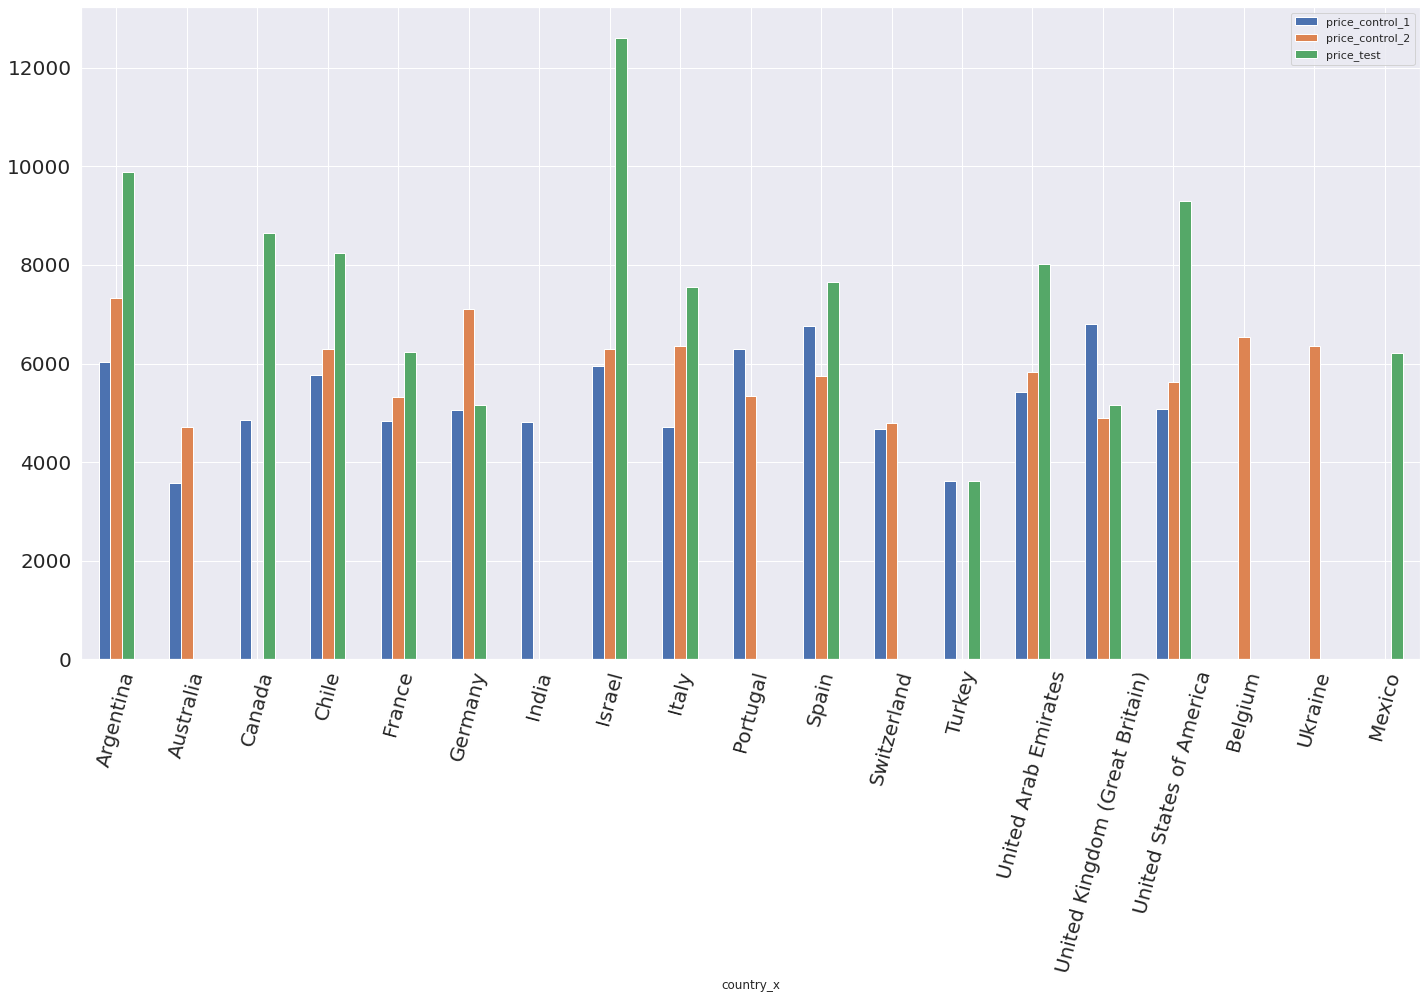

In [102]:
# График распределения цен по странам в разрезе по группам эксперимента:

sns.set(
         rc={'figure.figsize':(24,12)}
        )


countries_merged[['country_x', 'price_control_1', 'price_control_2', 'price_test']] \
.plot(x='country_x', kind='bar', rot=75, fontsize=20) 


In [103]:
# есть странные изменения цен между группами по некоторым странам, посчитаем изменения в процентах:

In [104]:
countries_merged['change_rate_c2_to_c1'] = round((countries_merged.price_control_2 / countries_merged.price_control_1 - 1) * 100, 2)
countries_merged['change_rate_test_to_c1'] = round((countries_merged.price_test / countries_merged.price_control_1 - 1) * 100, 2)
countries_merged['change_rate_test_to_c2'] = round((countries_merged.price_test / countries_merged.price_control_2 - 1) * 100, 2)

countries_merged

,country_x,price_control_1,price_control_2,price_test,change_rate_c2_to_c1,change_rate_test_to_c1,change_rate_test_to_c2
0,Argentina,6038.50,7325.50,9882.60,21.31,63.66,34.91
1,Australia,3588.00,4719.00,NaN,31.52,NaN,NaN
2,Canada,4849.00,NaN,8651.50,NaN,78.42,NaN
3,Chile,5776.33,6292.00,8242.00,8.93,42.69,30.99
4,France,4840.33,5317.00,6233.50,9.85,28.78,17.24
5,Germany,5053.75,7111.00,5167.50,40.71,2.25,-27.33
6,India,4810.00,NaN,NaN,NaN,NaN,NaN
7,Israel,5943.89,6292.00,12597.00,5.86,111.93,100.21
8,Italy,4719.00,6361.33,7543.25,34.80,59.85,18.58
9,Portugal,6292.00,5343.00,NaN,-15.08,NaN,NaN


----------------
**Будем считать, что изменение цены до ~20% является погрешностью курса валют.**  

**Что имеем с учетом этого:**  

**Значительная разница в цене между контрольными группами (нечистый эксперимент):**   
Australia, Germany, Italy, United Kingdom (Great Britain).

**Нет или почти нет изменений в тестовой группе относительно хотя бы одной из контрольных:**  
Turkey, Germany, United Kingdom (Great Britain).

**снижение цены в тесте относительно контрольных групп:**  
United Kingdom (Great Britain)  
(в целом снижение цены удовлетворяет условиям теста, т.к. по вводным цена "изменилась", не обязательно увеличилась, но 1) изменения близко к 20% в тесте относительно контрольной группы 1 и близко к нулю относительно контрольной группы 2. 2) есть значительная разница в стоимости между контрольными группами. Не будем брать эту страну в расчет).    

**Тест не задался (не было новых пользователей с покупкой премиума в тестовой группе)**:   
Australia, Belgium, India, Portugal, Switzerland, Ukraine.  
    
**Не было новых пользователей с покупкой премиума в обеих контрольных группах:**   
Mexico.


**Итого, далее будем исключать из анализа следующие страны:**  

Australia, Belgium, Germany, Italy, Turkey, United Kingdom (Great Britain), India, Portugal, Switzerland, Ukraine, Mexico (11 стран из 19 стран, в которых были покупки премиум-подписки без пробника новыми пользователями).

-----------------




In [105]:
country_list = ['Australia', 'Belgium', 'Germany', 'Italy', 'Turkey', 'United Kingdom (Great Britain)', 'India', 'Portugal', 'Switzerland', 'Ukraine', 'Mexico']

In [106]:
df_merged = df_merged.query('country_x not in @country_list and uid not in @suspicious_uids')

-----------------------
### Резюме по разведочному анализу:

- Конкретная дата регистрации в данных доступна только по тем пользователям, которые совершили покупку;  
- В вводных имеется инфо, что измененная цена премиум-подписки предлагалась именно новым пользователям. Т.к. нет очевидного указателя на "новизну" пользователя, будем считать, что оставшиеся после обработки пользователи, попавших в группы эксперимента, для нашего сервиса являются новыми, попавшими в базу впервые;

- Также у нас нет данных о типах платежных систем, про которые упоминается в задаче, этой переменной мы также не сможем оперировать и будем считать, что в тесте только наши две платежные системы и участвовали;  
- Столбцы was_premium, is_premium и payment_id, visit_days - не используем в анализе (но хотелось бы перепроверить их на баги в рамках отдельной задачи);

- Дополнительно будем учитывать, что экспреримент проводился в течение года (2017-01-11 - 2017-12-11), а значения по датам регистрации и покупки не-пустые только у пользователей, которые совершали покупки (по остальным юзерам нет даты регистрации).

- В ходе анализа были выявлены несколько записей о пользователях с аномальными суммами транзакций на исключение из дальнейшего анализа, а также данные по нескольким странам на исключение из дальнейшего анализа (по странам - основываясь на предположении о курсе валют и на данных с аномальной разницей в стоимости премиума в контрольных группах).  

- **В результате предобработки данных было подтверждено наличие изменений в стоимости премиум-подписки в тестовой группе. Ниже приведена итоговая таблица со средними значениями этой метрики по группам эксперимента.**

In [107]:
pd.DataFrame({'Группа': 
              ['Контрольная 1', 'Контрольная 2', 'Тестовая'],
              'Цена премиум-подписки': 
              [round(control_group_1_premium_newusers_3.query('country_x not in @country_list').revenue.sum() / control_group_1_premium_newusers_3.query('country_x not in @country_list').product_type.count(), 2), 
               round(control_group_2_premium_newusers_3.query('country_x not in @country_list').revenue.sum() / control_group_2_premium_newusers_3.query('country_x not in @country_list').product_type.count(), 2), 
               round(test_group_premium_newusers_3.query('country_x not in @country_list').revenue.sum() / test_group_premium_newusers_3.query('country_x not in @country_list').product_type.count(), 2)]})

,Группа,Цена премиум-подписки
0,Контрольная 1,5412.25
1,Контрольная 2,5853.48
2,Тестовая,8883.69


---------------------

# Проверка групп эксперимента на репрезентативность

Проверим уже очищенные ранее данные.  
Задачей проверки групп на репрезентативность является выявление возможных отклонений (выбросов) в количестве юзеров, разбитых по различным подгруппам. Отсутствие значительных девиаций по таким подгруппам (возраст, страна, пол), будет свидетельствовать о релевантности состава групп для проведения тестирования.

In [108]:
# Распределение юзеров по группам по странам: 

country_test = test_group.groupby('country_x', as_index=False).agg({'uid' : 'count'})
country_cntr_1 = control_group_1.groupby('country_x', as_index=False).agg({'uid' : 'count'})
country_cntr_2 = control_group_2.groupby('country_x', as_index=False).agg({'uid' : 'count'})
country = country_test.merge(country_cntr_1, on = 'country_x').merge(country_cntr_2, on = 'country_x')
country = country.rename(columns={'uid_x' : 'test', 'uid_y' : 'control_1', 'uid' : 'control_2'})

country.sort_values('test', ascending=False)

,country_x,test,control_1,control_2
24,United States of America,1466,1494,1507
0,Argentina,399,392,400
8,France,355,374,373
12,Italy,325,372,306
18,Spain,300,346,310
4,Chile,273,291,286
22,United Arab Emirates,227,208,210
9,Germany,210,190,200
23,United Kingdom (Great Britain),171,142,154
3,Canada,136,134,135


In [109]:
# между группами аномалий в количестве юзеров по странам нет, переходим к 

# оценке распределения юзеров по группам по полу:

gender_test = test_group.groupby('gender', as_index=False).agg({'uid' : 'count'})
gender_control_1 = control_group_1.groupby('gender', as_index=False).agg({'uid' : 'count'})
gender_control_2 = control_group_2.groupby('gender', as_index=False).agg({'uid' : 'count'})
gender = gender_test.merge(gender_control_1, on = 'gender').merge(gender_control_2, on = 'gender') \
        .rename(columns={'uid_x' : 'test', 'uid_y' : 'control_1', 'uid' : 'control_2'})

gender

,gender,test,control_1,control_2
0,0,202,181,195
1,1,4138,4234,4127


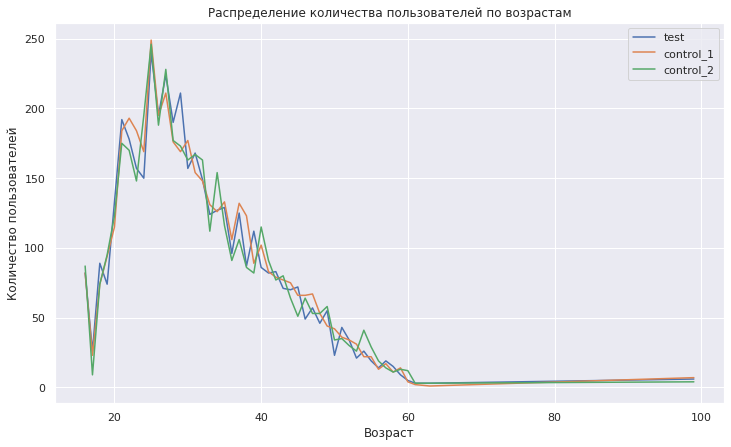

In [110]:
# между группами аномалий в количестве юзеров по полу нет, переходим к 

# оценке распределения юзеров по группам по возрасту:

age_test = test_group.groupby('age', as_index=False).agg({'uid' : 'count'})
age_cntr_1 = control_group_1.groupby('age', as_index=False).agg({'uid' : 'count'})
age_cntr_2 = control_group_2.groupby('age', as_index=False).agg({'uid' : 'count'})
age = age_test.merge(age_cntr_1, on = 'age').merge(age_cntr_2, on = 'age') \
      .rename(columns={'uid_x' : 'test', 'uid_y' : 'control_1', 'uid' : 'control_2'})

plt.figure(figsize=(12, 7))
plt.plot(age.age, age.test, label = 'test')
plt.plot(age.age, age.control_1, label = 'control_1')
plt.plot(age.age, age.control_2, label = 'control_2')
plt.title('Распределение количества пользователей по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid(True)


**С составом групп по странам, полу и возрасту все ОК, группы репрезентативны, можем приступать к анализу метрик.**

----------------------
### Вернемся к задаче проекта:  

-----------------

**Какова цель премиум-подписки для бизнеса?**  
Основная цель - повышение выручки  
Дополнительная - удержание пользователей (как следствие - лояльность)


**Какое преимущество дает премиум-подписка пользователю?**  
В задании нет прямого ответа на этот вопрос, есть лишь формулировка, что подписка "дает доступ к ряду важных дополнительных возможностей". Можно предположить, что это бОльшее число показов профиля пользователя (другим пользователям), выведение в топ выдачи (как конечная цель - больше мэтчей/взаимодействий).

### Какова цель A/B теста?  
Проверить, сможем ли мы привлекать больше выручки, повысив стоимость подписки  
aka  
не уроним ли мы конверсию в покупку подписки, предлагая новым клиентам более высокую стоимость подписки  


### **Задачи анализа:**  
**Проверить, был ли эксперимент успешен в целом**, то есть:
- корректно ли он проведен
- можно ли назвать результат эксперимента удовлетворительным  
(если конверсия и/или Retention значимо снизились, то на долгосрочной перспективе увеличенная стоимость подписки (средний чек) может отразиться негативно на показателях бизнеса и не привести к увеличению выручки, даже если в моменте (в рамках эксперимента) сама по себе выручка увеличилась.


# Какие метрики будем проверять?
* Конверсию в покупку премиума
* Выручку на пользователя (ARPU тотал по всем продуктам и отдельно по премиуму)
* Повторные покупки премиума  

---------------


Перед проведением A/A- и A/B-тестов рассмотрим значения этих метрик по группам эксперимента:

**Конверсия в первую покупку премиума:**  
*(из первого визита в первую покупку премиума)*

In [111]:
pd.DataFrame({'Группа': ['Контрольная 1', 'Контрольная 2', 'Тестовая'], 'Конверсия в первую покупку премиума, %': 
              [round(control_group_1_premium_newusers_3.query('country_x not in @country_list').product_type.count() / control_group_1.query('country_x not in @country_list').uid.nunique() * 100, 2),
               round(control_group_2_premium_newusers_3.query('country_x not in @country_list').product_type.count() / control_group_2.query('country_x not in @country_list').uid.nunique() * 100, 2), 
               round(test_group_premium_newusers_3.query('country_x not in @country_list').product_type.count() / test_group.query('country_x not in @country_list').uid.nunique() * 100, 2)]})

,Группа,"Конверсия в первую покупку премиума, %"
0,Контрольная 1,1.66
1,Контрольная 2,1.70
2,Тестовая,1.10


------------------
**Средняя выручка на пользователя (ARPU):**

In [112]:
# средняя выручка на пользователя по группам (total по всем продуктам):

rev_1 = df_merged.groupby(['group'], as_index = False).agg({'revenue': 'sum'})
rev_2 = df_merged.groupby(['group'], as_index = False).agg({'uid': 'nunique'})
rev_mean = rev_1.merge(rev_2)
rev_mean['ARPU'] = round(rev_mean.revenue / rev_mean.uid, 2)
rev_mean.drop(['revenue', 'uid'], axis= 1, inplace= True)

rev_mean

,group,ARPU
0,control_1,347.32
1,control_2,261.40
2,test,402.93


In [113]:
# средняя выручка от премиума (premium_no_trial) на пользователя по группам:

rev_3 = df_merged.query('product_type == "premium_no_trial"').groupby(['group'], as_index = False).agg({'revenue': 'sum'})
rev_4 = df_merged.groupby(['group'], as_index = False).agg({'uid': 'nunique'})
rev_prem_mean = rev_3.merge(rev_4)
rev_prem_mean['ARPU_prem'] = round(rev_prem_mean.revenue / rev_prem_mean.uid, 2)
rev_prem_mean.drop(['revenue', 'uid'], axis= 1, inplace= True)

rev_prem_mean

,group,ARPU_prem
0,control_1,103.00
1,control_2,108.52
2,test,146.11


In [114]:
# Средняя выручка на платящего пользователя в разрезе по продуктам и группам (ARPPU)
# (привожу лишь для наглядности, тут можно отметить, что в целом по всем продуктам 
# средняя выручка с платяшего пользователя увеличилась (не только по премиуму).
    
rev_mean_by_product = df_merged.groupby(['product_type', 'group'], as_index = False).agg({'revenue': 'mean'}) \
.pivot_table('revenue', index = 'product_type', columns = 'group', aggfunc = 'mean') \
.round()

rev_mean_by_product

group,control_1,control_2,test
product_type,,,
coins,3918.0,2908.0,6748.0
other_type,4518.0,3132.0,4679.0
premium_no_trial,5420.0,5753.0,11376.0
trial_premium,11509.0,11908.0,12956.0


-----------------
**средняя кол-во покупок премиума на пользователя по группам:**

In [115]:
# список пользователей, которые покупали премиум (не пробный):

bought_premium_uids_2 = df_merged.query('product_type == "premium_no_trial"').uid.tolist()


# Таблица с количеством покупок премиума на пользователя:

prem_purch_count = df_merged.query('uid in @bought_premium_uids_2 and product_type == "premium_no_trial"') \
.groupby(['uid', 'group'], as_index = False).agg({'product_type': 'count'}) \
.sort_values('product_type', ascending = False) \
.rename(columns = {'product_type': 'num_of_purchases'})


# среднее кол-во покупок премиума на пользователя в группах:

round(prem_purch_count.groupby('group', as_index = False).agg({'num_of_purchases': 'mean'}), 2)

,group,num_of_purchases
0,control_1,1.05
1,control_2,1.02
2,test,1.08


-----------------------
# A/A-тесты

Сначала проведем АА-анализ на двух контрольных группах.  
Если они значимо не различаются по целевым метрикам - это будет значить, что тест проведен корректно по части сплитования.
И тогда в дальнейшем сможем сравнивать тестовую группу с одной из контрольных, либо с объединенной контрольной (состоящей из двух контрольных) ((AB-тест).

-----------

В объединенной таблице df_merged оставим только новых пользователей (т.е. только первые записи о каждом id),  
а также исключим страны из списка выше и список подозрительных uid: 

In [116]:
# Таблица с новыми пользователями (уникальные uid) с исключением всех "подозрительных" uid и стран.

df_merged = df_merged.sort_values('paid_at').drop_duplicates(subset=['uid']).query('country_x not in @country_list and uid not in @suspicious_uids')

df_merged.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
3919,891556971,35,666,NaN,France,"1,3",1,32,38,3,...,NaN,2886,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886.0,68.0,none,premium_no_trial,control_1
3561,891561825,32,208,8.0,France,"1,2,3,4,5,8,11",1,29,35,24,...,1.0,20449,France,2017-01-11 01:06:00,2017-01-11 13:33:00,3913.0,146.0,empty_likes,coins,control_1
4414,891543996,50,508,NaN,United States of America,NaN,1,26,53,120,...,1.0,6292,United States of America,2017-01-11 13:42:00,2017-01-11 14:41:00,6292.0,147.0,user_profile,premium_no_trial,control_1
3614,891545874,34,641,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,14",1,31,37,53,...,1.0,12597,United States of America,2017-01-11 12:50:00,2017-02-11 13:43:00,12597.0,147.0,send_message,premium_no_trial,test
5,891497961,28,400,28.0,Chile,"1,2",1,25,31,25,...,NaN,6396,Chile,2017-02-11 15:07:00,2017-02-11 17:16:00,2418.0,67.0,gifts,other_type,control_1


# A/A-тест: CR в первую покупку премиума

In [117]:
# Посчитаем уников и покупки премиума, сгруппируем по группам эксперимента.
# Создадим столбец с конверсией, которая в рамках каждого uid будет принимать значения 0 или 1 (была покупка премиума или нет).

# Уники
a = df_merged.groupby(['group', 'uid'], as_index = False).agg({'age': 'nunique'})


# Покупки премиума
b = df_merged \
.sort_values('paid_at') \
.drop_duplicates(subset=['uid']) \
.query('product_type == "premium_no_trial"') \
.groupby(['group', 'uid'], as_index = False) \
.agg({'age': 'nunique'})

# Соединяем и добавляем конверсию:
stat = a.merge(b, on = ['group', 'uid'], how = 'left').rename(columns = {'age_x': 'first_visit', 'age_y': 'premium_purchases'})
stat["CR"] = stat.premium_purchases / stat.first_visit
stat = stat.fillna(0)

stat

,group,uid,first_visit,premium_purchases,CR
0,control_1,891050997,1,0.0,0.0
1,control_1,891051552,1,0.0,0.0
2,control_1,891051606,1,0.0,0.0
3,control_1,891053274,1,0.0,0.0
4,control_1,891053538,1,0.0,0.0
...,...,...,...,...,...
9867,test,892439721,1,0.0,0.0
9868,test,892440117,1,0.0,0.0
9869,test,892440774,1,0.0,0.0
9870,test,892440783,1,0.0,0.0


In [118]:
# Та же таблица только с обеими контрольными группами (без тестовой): 

stat_both_control = stat.query('group != "test"')

In [119]:
# Таблица сопряженности, 
# показывающая количество уникальных юзеров с конверсией в покупку премиума и без - по двум контрольным группам.

pd.crosstab(stat_both_control.group, stat_both_control.CR, values=stat_both_control.CR, aggfunc='count')

CR,0.0,1.0
group,,
control_1,3260,55
control_2,3231,56


Проверим, можно ли сказать, что есть зависимость переменных (группа эксперимента и конверсия в покупку премиума).  
=> Сравниваем качественные метрики 
и применяем самый подходящий на такой случай тест - критерий согласия Пирсона (хи-квадрат).

Нулевая гипотеза: переменные не связаны друг с другом.  
Альтернативная гипотеза: есть связь между переменными.

За порог значимости (α) здесь и далее принимаем значение 0.05.

In [120]:
statistics, p, dof, expected = chi2_contingency(pd.crosstab(stat_both_control.group, stat_both_control.CR, values=stat_both_control.CR, aggfunc='count'))

statistics, p

(0.0020307652543843746, 0.9640562858495489)

In [121]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


### p-value = 96%, следовательно нельзя утверждать, что нулевая гипотеза неверна, что значит, что у нас нет достаточных доказательств, чтобы сказать, что существует связь между группой эксперимента (в контроле) и конверсией в покупку премиума.

--------------------
# A/A-тест: средняя выручка на пользователя (ARPU)

In [122]:
# т.к. в df_merged мы оставили только первые упоминания о каждом пользователе, 
# создадим новый df без такой фильтрации:

kk = test_group.append(control_group_1, sort = False).append(control_group_2, sort = False)
kk = kk.query('country_x not in @country_list and uid not in @suspicious_uids')

In [123]:
# Таблица с суммами выручки на каждого пользователя по группам эксперимента:

total_revenue = kk.groupby(['group', 'uid'], as_index = False).agg({'revenue': 'sum'})

total_revenue.head()

,group,uid,revenue
0,control_1,891050997,0.0
1,control_1,891051552,0.0
2,control_1,891051606,0.0
3,control_1,891053274,0.0
4,control_1,891053538,0.0


In [124]:
# Средняя выручка на пользователя по группам 
# (еще раз посмотрим на нее и убедимся, что выше, перед А/А-тестами, посчитали корректно):

total_revenue.groupby('group', as_index = False).agg({'revenue': 'mean'}).round(2)

,group,revenue
0,control_1,347.32
1,control_2,261.40
2,test,402.93


In [125]:
# Размеры групп: 

total_revenue.groupby('group').size()

group
control_1    3315
control_2    3287
test         3270
dtype: int64

Размеры групп похожи и достаточны для того, чтобы при выборе теста не ограничиваться условием нормальности распределения.

In [126]:
# тест на гомогенность данных между контрольными группами:

stats.levene(total_revenue.query('group == "control_1"').revenue, total_revenue.query('group == "control_2"').revenue, center='mean')

LeveneResult(statistic=13.18777100658682, pvalue=0.00028391847709452505)

Но имеем негомогенные данные между контрольными группами.   
Применим t-критерий Уэлча.


Нулевая гипотеза: средние значения выручки на пользователя в двух контрольных группах равны.  
Альтернативная гипотеза: средние значения выручки на пользователя в двух контрольных группах не равны.

In [127]:
stats.ttest_ind(total_revenue.query('group == "control_1"').revenue, total_revenue.query('group == "control_2"').revenue, equal_var=False)


Ttest_indResult(statistic=1.8160722802257285, pvalue=0.06940647365019767)

### На основании значения pvalue (> 0.05) не отвергаем нулевую гипотезу и считаем, что изменение средней выручки на пользователя между контрольными группыми можно назвать не стат. значимым.

---------------------------
# A/A-тест: средняя выручка от покупок премиума на пользователя (ARPU_prem)

In [128]:
# для дальнейших расчетов создадим доп. колонку в таблице kk, показывающую выручку от премиума в каждой строке:

kk['prem_revenue']  = np.where(kk['product_type'] == 'premium_no_trial', kk.revenue, 0)

kk.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,prem_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,...,0,NaN,NaT,NaT,NaN,nan,NaN,nan,test,0.0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,...,0,NaN,NaT,NaT,NaN,nan,NaN,nan,test,0.0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,...,0,NaN,NaT,NaT,NaN,nan,NaN,nan,test,0.0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,...,0,NaN,NaT,NaT,NaN,nan,NaN,nan,test,0.0
5,891083133,24,0,NaN,Spain,1,1,16,27,0,...,0,NaN,NaT,NaT,NaN,nan,NaN,nan,test,0.0


In [129]:
# Таблица с суммами выручки с покупок премиума (premium_no_trial) на каждого пользователя по группам эксперимента:

premium_revenue = kk.groupby(['group', 'uid'], as_index = False).agg({'prem_revenue': 'sum'})

premium_revenue.head()

,group,uid,prem_revenue
0,control_1,891050997,0.0
1,control_1,891051552,0.0
2,control_1,891051606,0.0
3,control_1,891053274,0.0
4,control_1,891053538,0.0


In [130]:
# Размеры групп: 

premium_revenue.groupby('group').size()

group
control_1    3315
control_2    3287
test         3270
dtype: int64

In [131]:
# тест на гомогенность данных между контрольными группами:

stats.levene(premium_revenue.query('group == "control_1"').prem_revenue, premium_revenue.query('group == "control_2"').prem_revenue, center='mean')

LeveneResult(statistic=0.31120738680243837, pvalue=0.5769591489589309)

Размеры групп похожи, достаточны для того, чтобы при выборе теста не ограничиваться условием нормальности распределения, данные гомогенны.  
Применяем стандартный t-test.

Нулевая гипотеза: средние значения выручки c премиума на пользователя в двух контрольных группах равны.  
Альтернативная гипотеза: средние значения выручки c премиума на пользователя в двух контрольных группах не равны.

In [132]:
stats.ttest_ind(premium_revenue.query('group == "control_1"').prem_revenue, premium_revenue.query('group == "control_2"').prem_revenue, equal_var=True)


Ttest_indResult(statistic=-0.27710025802812666, pvalue=0.781711801699906)

### На основании значения pvalue (> 0.05) не отвергаем нулевую гипотезу и считаем, что изменение средней выручки c премиума на пользователя между контрольными группыми нельзя назвать стат. значимым.

------------------
# A/A-тест: повторные покупки премиума 



In [133]:
# Таблица с количеством покупок премиума на пользователя:

prem_purch_count

,uid,group,num_of_purchases
117,892097937,test,3
159,892435536,control_2,2
118,892101909,control_1,2
75,891725043,test,2
18,891264903,control_1,2
...,...,...,...
55,891482937,control_2,1
56,891497391,control_1,1
57,891499695,test,1
58,891508155,test,1


In [134]:
# Вспомним среднее кол-во покупок премиума на пользователя в группах:

round(prem_purch_count.groupby('group', as_index = False).agg({'num_of_purchases': 'mean'}), 2)

,group,num_of_purchases
0,control_1,1.05
1,control_2,1.02
2,test,1.08


Видим, что в тестовой группе значение немного больше, чем в контрольных
(отдельный вопрос, конечно, почему в целом значения такие низкие, при условии, что данные за год, а подписка ежемесячная,  
но это уже вопрос к отдельному исследованию про ретеншн и отток пользователей).

Проверим стат. значимость различия метрики между контрольными группами:


In [135]:
# Размерность групп:

prem_purch_count.groupby('group').size()

group
control_1    60
control_2    61
test         39
dtype: int64

In [136]:
# тест на гомогенность данных между контрольными группами:

stats.levene(prem_purch_count.query('group == "control_1"').num_of_purchases, prem_purch_count.query('group == "control_2"').num_of_purchases, center='mean')

LeveneResult(statistic=4.389908863850223, pvalue=0.03827284966090541)

Данных в группах достаточно, но они не гомогенные и не совсем похожи по размеру. Применим в этот раз bootstrap.

Нулевая гипотеза: среднее кол-во покупок премиум-тарифа в контрольных группах одинаковое.  
Альтернативная гипотеза: среднее кол-во покупок премиум-тарифа в контрольных группах различается.



In [137]:
# Функция для bootstrap

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

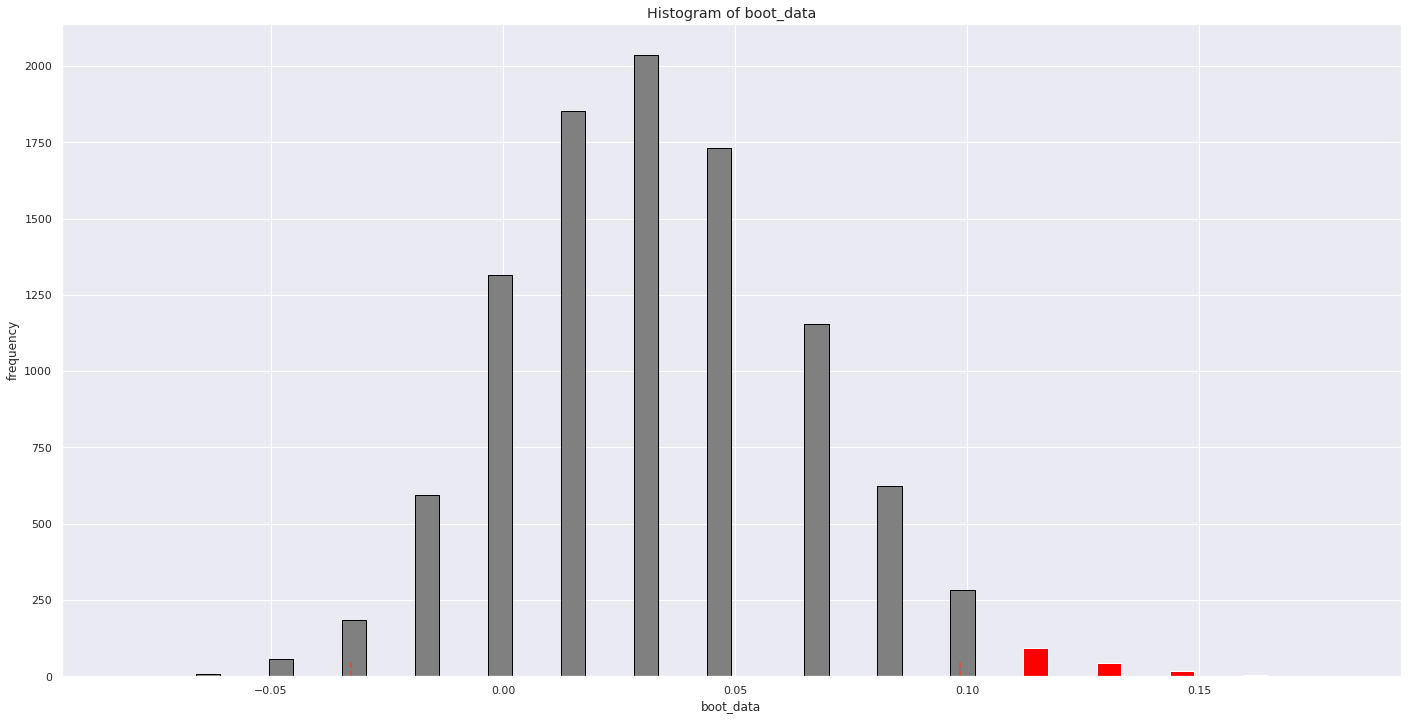

In [138]:
rep_purch_AA = get_bootstrap(prem_purch_count.query('group == "control_1"').num_of_purchases,
                                 prem_purch_count.query('group == "control_2"').num_of_purchases)

In [139]:
rep_purch_AA_p = round(rep_purch_AA['p_value'],3)
rep_purch_c1 = round(prem_purch_count.query('group=="control_1"').num_of_purchases.mean(),2)
rep_purch_c2 = round(prem_purch_count.query('group=="control_2"').num_of_purchases.mean(),2)
print(f'Среднее кол-во повторных покупок для контрольной группы №1 равно {rep_purch_c1}, для контрольной группы №2 - {rep_purch_c2}')
print(f'p-value bootstrap-теста = {rep_purch_AA_p}')

Среднее кол-во повторных покупок для контрольной группы №1 равно 1.05, для контрольной группы №2 - 1.02
p-value bootstrap-теста = 0.296


### p-value > 5%, что не дает нам оснований утверждать, что нулевая гипотеза неверна.  
### Т.е. среднее кол-во покупок премиум-тарифа в двух контрольных группах значимо не различается.

----------------
# A/A-тесты: резюме
В результате проверки выше можно утверждать, что сплитование пользователей было проведено корректно,  
и можем переходить к сравнению тестовой группы с контрольми. 

--------------

# А/B-тесты

# А/B-тест: CR в первую покупку премиума


In [140]:
# таблица с конверсиями в первую покупку премиума по группам и пользователям:
stat

,group,uid,first_visit,premium_purchases,CR
0,control_1,891050997,1,0.0,0.0
1,control_1,891051552,1,0.0,0.0
2,control_1,891051606,1,0.0,0.0
3,control_1,891053274,1,0.0,0.0
4,control_1,891053538,1,0.0,0.0
...,...,...,...,...,...
9867,test,892439721,1,0.0,0.0
9868,test,892440117,1,0.0,0.0
9869,test,892440774,1,0.0,0.0
9870,test,892440783,1,0.0,0.0


In [141]:
# Заменим значения control_1 и control_2 на "control", тем самым объединив две контрольные группы в одну:

stat_2 = stat.replace(['control_1', 'control_2'],' control')

In [142]:
# Таблица сопряженности, 
# показывающая количество уникальных юзеров с конверсией в покупку премиума и без - суммарно в контрольных группах и в тестовой.

pd.crosstab(stat_2.group, stat_2.CR, values=stat_2.CR, aggfunc='count')

CR,0.0,1.0
group,,
control,6491,111
test,3234,36


Проверим, можно ли сказать, что есть зависимость переменных (группа эксперимента и конверсия в покупку премиума).
=> Сравниваем качественные метрики, 
и снова применяем критерий согласия Пирсона (хи-квадрат).

Нулевая гипотеза: переменные не связаны друг с другом.  
Альтернативная гипотеза: есть связь между переменными.

In [143]:
statistics, p, dof, expected = chi2_contingency(pd.crosstab(stat_2.group, stat_2.CR, values=stat_2.CR, aggfunc='count'))

statistics, p

(4.633975362984872, 0.03134485604047658)

In [144]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


### на основе значения pvalue (< 0.05) отвергаем нулевую гипотезу и считаем, что при том, что конверсия в тестовой группе упала относительно конверсии в контрольных группах, различия  являются статистически значимыми.


----------------
# A/B-тест: средняя выручка на пользователя (ARPU)

In [145]:
# тест на гомогенность данных между контрольными и тестовой группами:

stats.levene(total_revenue.query('group != "test"').revenue, total_revenue.query('group == "test"').revenue, center='mean')

LeveneResult(statistic=12.082400094439167, pvalue=0.0005111893605459421)

Размеры групп похожи и достаточны для того, чтобы при выборе теста не ограничиваться условием нормальности распределения.
Но имеем негомогенные данные между контрольными группами.  
Снова применим t-критерий Уэлча.  

Нулевая гипотеза: средние значения выручки на пользователя в контрольных и тестовой группах равны.  
Альтернативная гипотеза: средние значения выручки на пользователя в контрольных и тестовой группах не равны.

In [146]:
stats.ttest_ind(total_revenue.query('group != "test"').revenue, total_revenue.query('group == "test"').revenue, equal_var=False)


Ttest_indResult(statistic=-1.3799819389643269, pvalue=0.16766747320383882)

### т.к. p-value > 0.05, не отвергаем нулевую гипотезу и считаем, что изменение (увеличение) средней выручки на пользователя в тестовой группе нельзя назвать стат. значимым.


-----------------------
# A/B-тест: средняя выручка от покупок премиума на пользователя (ARPU_prem)

In [147]:
# тест на гомогенность данных между контрольными группами:

stats.levene(premium_revenue.query('group == "control_1"').prem_revenue, premium_revenue.query('group == "control_2"').prem_revenue, center='mean')

LeveneResult(statistic=0.31120738680243837, pvalue=0.5769591489589309)

Размеры групп похожи, достаточны для того, чтобы при выборе теста не ограничиваться условием нормальности распределения (эти условия проверены выше при A/A-тесте), данные гомогенны. Применяем t-test.  

Нулевая гипотеза: средние значения выручки с премиума на пользователя в контрольных и тестовой группах равны.  
Альтернативная гипотеза: средние значения выручки с премиума на пользователя в контрольных и тестовой группах не равны.

In [148]:
stats.ttest_ind(premium_revenue.query('group != "test"').prem_revenue, premium_revenue.query('group == "test"').prem_revenue, equal_var=True)


Ttest_indResult(statistic=-1.2870644964113376, pvalue=0.19810199139364398)

### т.к. p-value > 0.05, не отвергаем нулевую гипотезу и считаем, что изменение (увеличение) средней выручки с премиума на пользователя в тестовой группе также можно назвать не стат. значимым.

_______________
# A/B-тест: повторные покупки премиума 


In [149]:
# Таблица с количеством покупок премиума на пользователя:

prem_purch_count

,uid,group,num_of_purchases
117,892097937,test,3
159,892435536,control_2,2
118,892101909,control_1,2
75,891725043,test,2
18,891264903,control_1,2
...,...,...,...
55,891482937,control_2,1
56,891497391,control_1,1
57,891499695,test,1
58,891508155,test,1


In [150]:
# тест на гомогенность данных между тестовой и первой контрольной группами:

stats.levene(prem_purch_count.query('group == "test"').num_of_purchases, prem_purch_count.query('group == "control_1"').num_of_purchases, center='mean')

LeveneResult(statistic=0.9529909957500962, pvalue=0.3313874698738226)

In [151]:
# тест на гомогенность данных между тестовой и второй контрольной группами:

stats.levene(prem_purch_count.query('group == "test"').num_of_purchases, prem_purch_count.query('group == "control_2"').num_of_purchases, center='mean')

LeveneResult(statistic=6.204237823460724, pvalue=0.01442555306709117)

In [152]:
# тест на гомогенность данных между тестовой и склеенной контрольной группами:

stats.levene(prem_purch_count.query('group == "test"').num_of_purchases, prem_purch_count.query('group != "test"').num_of_purchases, center='mean')

LeveneResult(statistic=4.2882627214399935, pvalue=0.04000287591495021)

Имеем достаточное кол-во данных, но гомогенность подтвердилась только в сравнении с первой контрольной группой. Можем сравнить средние тестовой и первой контрольной группы с применением t-test.  


Нулевая гипотеза: среднее кол-во покупок премиум-тарифа в тестовой и контрольной группах одинаковое.  
Альтернативная гипотеза: среднее кол-во покупок премиум-тарифа в тестовой и контрольной группах различается.

In [153]:
stats.ttest_ind(prem_purch_count.query('group == "test"').num_of_purchases, prem_purch_count.query('group == "control_1"').num_of_purchases)

Ttest_indResult(statistic=0.46703058944191256, pvalue=0.6415253625552397)

А сравнение со второй контрольной группой и со склеенной группой (состоящей из двух контрольных) проведем с помощью t-критерия Уэлча:

In [154]:
stats.ttest_ind(prem_purch_count.query('group == "test"').num_of_purchases, prem_purch_count.query('group == "control_2"').num_of_purchases, equal_var=False)


Ttest_indResult(statistic=1.0250651184620538, pvalue=0.31088308770520373)

In [155]:
stats.ttest_ind(prem_purch_count.query('group != "test"').num_of_purchases, prem_purch_count.query('group == "test"').num_of_purchases, equal_var=False)


Ttest_indResult(statistic=-0.7431070815091501, pvalue=0.4613260790908559)

### во всех случаях тут p-value > 5%, что не дает нам оснований утверждать, что нулевая гипотеза неверна. Т.е. среднее кол-во покупок премиум-тарифа в тестовой и контрольной группах значимо не различается.


--------------------------------------

----------------------------
# Выводы:

**В результате эксперимента**  
   
* **конверсия в оплату премиума статистически значимо снизилась** (1.66% - 1.7% в контроле VS 1.1% в тесте), 
* **средняя выручка на пользователя увеличилась НЕ статистически значимо** (347.32 и 261.4 в контроле VS 402.93 в тесте), 
* **средняя выручка с премиума на пользователя увеличилась НЕ статистически значимо** (103 и 108.52 в контроле VS 146.11 в тесте),  
* **проведение эксперимента не повлияло на кол-во повторных покупок премиума,**

**следовательно, эксперимент признаем НЕ успешным, изменения рекомендуется откатить и не масштабировать**,

т.к. при значимом снижении конверсии в долгосрочной перспективе даже увеличенная в моменте выручка (на выборке) покажет обратный эффект (в генеральной совокупности) и с большой вероятностью может негативно отразиться на показателях бизнеса.  


----------
P.S.:  
Несмотря на репрезентативность выборок и корректно проведенный тест, перед проведением новых экспериментов стоит дополнительно проанализировать (вооружившись более точными / полными данными):  
Retention Rate, доли новых и вернувшихся пользователей.

Какие показатели стоит обогатить / пофиксить:  
дата регистрации   
тип платежной системы  
was_premium   
is_premium   
